## Mathematics and Portuguese grades prediction (Supervised learning)

This supervised learning problem seeks to predict a student's Mathematics (no. of students = 395) and Portuguese (no. of students = 649) final grade (G3). Two data sets are provided with the students' past performance on Mathematics (mat) and Portuguese (por). 

The data is collected from two schools, (1) Mousinho da Silveira and (2) Gabriel Pereira in Portugal and it consists of 32 predictors (features) of the students’ habits, particulars and parental information. 

The maximum grade attainable for both subjects is 20. The average final scores are 10.42 for Mathematics and 11.91 for Portuguese.  

## Data prep

In [2]:
#### libraries ####
library(tidyverse) # data cleaning
library(caret)
library(caTools)
library(boot) # for bootstrap
library(leaps) # for forward, backward
library(MASS)
library(glmnet) # for lasso
library(rpart) # regression tree
library(rpart.plot) # plot tree
library(ipred) # bagging
library(gbm) # boosting
library(randomForest) # random forest
library(ggplot2) # plotting package
library(GGally) # plots
library(corrplot) # for correlation plot

In [3]:
# import student performance
math=read.table("student-mat.csv",sep=";",header=TRUE) # rename school1 to math
port=read.table("student-por.csv",sep=";",header=TRUE) # rename school2 to port

dim(math)
# [1] 395 observations  33 features

dim(port)
# [1] 649 observations 33 features

[1] 395  33

[1] 649  33

## Corelation Analysis

In [5]:
# convert math and port to int variables for correlation analysis
math1 = transform(math, 
                 school=as.integer(school),
                 sex=as.integer(sex),
                 address=as.integer(address),
                 famsize=as.integer(famsize),
                 Pstatus=as.integer(Pstatus),
                 Mjob=as.integer(Mjob),
                 Fjob=as.integer(Fjob),
                 reason=as.integer(reason),
                 guardian=as.integer(guardian),
                 schoolsup=as.integer(schoolsup),
                 famsup=as.integer(famsup),
                 paid=as.integer(paid),
                 activities=as.integer(activities),
                 nursery=as.integer(nursery),
                 higher=as.integer(higher),
                 internet=as.integer(internet),
                 romantic=as.integer(romantic)
                 )
port1 = transform(port, 
                 school=as.integer(school),
                 sex=as.integer(sex),
                 address=as.integer(address),
                 famsize=as.integer(famsize),
                 Pstatus=as.integer(Pstatus),
                 Mjob=as.integer(Mjob),
                 Fjob=as.integer(Fjob),
                 reason=as.integer(reason),
                 guardian=as.integer(guardian),
                 schoolsup=as.integer(schoolsup),
                 famsup=as.integer(famsup),
                 paid=as.integer(paid),
                 activities=as.integer(activities),
                 nursery=as.integer(nursery),
                 higher=as.integer(higher),
                 internet=as.integer(internet),
                  romantic=as.integer(romantic)
                 )

# corr data frame
corr = function(df){
    a = apply(df, 2, function(col)cor(col, df$G3))
    a = data.frame(sort(a))
    return(a)
}

In [7]:
round(head(corr(math1), 5),2) # failures, age, goout, romantic, traveltime
round(tail(corr(math1), 8),2) # Medu, higher, Fedu, reason, address

,sort.a.
failures,-0.36
age,-0.16
goout,-0.13
romantic,-0.13
traveltime,-0.12


,sort.a.
address,0.11
reason,0.12
Fedu,0.15
higher,0.18
Medu,0.22
G1,0.80
G2,0.90
G3,1.00


In [8]:
round(head(corr(port1), 5),2) # failures, school, Dalc, Walc, sex
round(tail(corr(port1), 8),2) # G1 and G2 omitted due to its high correlation to G3

,sort.a.
failures,-0.39
school,-0.28
Dalc,-0.20
Walc,-0.18
sex,-0.13


,sort.a.
address,0.17
Fedu,0.21
Medu,0.24
studytime,0.25
higher,0.33
G1,0.83
G2,0.92
G3,1.00


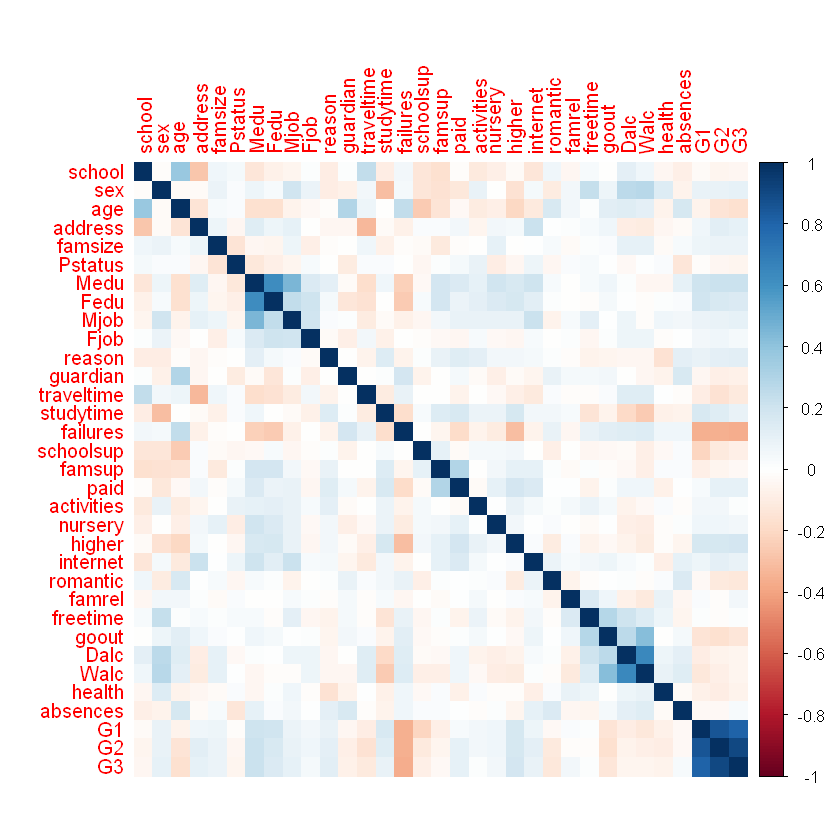

In [9]:
# correlation plot for mathematics
corrplot(cor(math1), method = "color")

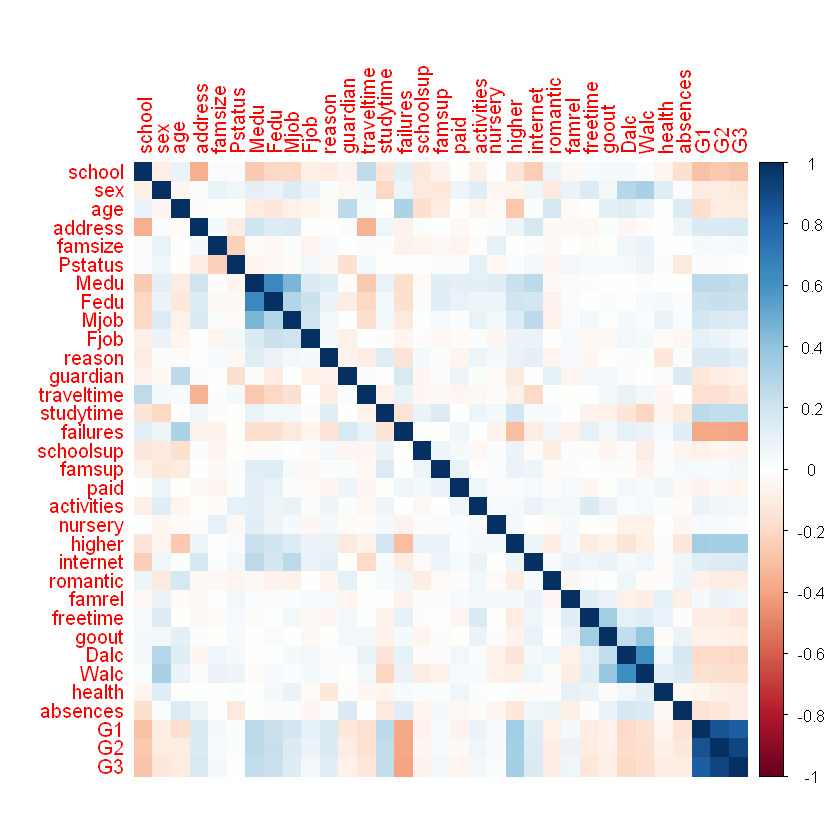

In [10]:
# correlation plot for Portuguese
corrplot(cor(port1), method = "color")

## Separate analysis of Mathematics and Portuguese grades

In [11]:
# remove G1, G2 strong linear correlation to G3
math2 = within(math, rm(G1, G2)) # mathematics data set
port2 = within(port, rm(G1, G2)) # portuguese data set

In [12]:
# transform additional variables to factor
math2 = transform(math2, # 
                  Medu=as.factor(Medu),
                  Fedu=as.factor(Fedu),
                  traveltime=as.factor(traveltime),
                  studytime=as.factor(studytime),
                  failures=as.factor(failures),
                 famrel=as.factor(famrel),
                 freetime=as.factor(freetime),
                 goout=as.factor(goout),
                 Dalc=as.factor(Dalc),
                 Walc=as.factor(Walc),
                 health=as.factor(health)
                 )
port2 = transform(port2, # convert to categorical for port
                  Medu=as.factor(Medu),
                  Fedu=as.factor(Fedu),
                  traveltime=as.factor(traveltime),
                  studytime=as.factor(studytime),
                  failures=as.factor(failures),
                 famrel=as.factor(famrel),
                 freetime=as.factor(freetime),
                 goout=as.factor(goout),
                 Dalc=as.factor(Dalc),
                 Walc=as.factor(Walc),
                 health=as.factor(health)
                 )

The data set is split into a train (80%) and test (20%) set. 

Each model is being trained on the training set (80%) and fitted on the test set (20%). The root mean squared error (RMSE) criterion is used on the test set for evaluating each model’s predictability. 

In [13]:
# rmse function
RMSE = function(error){ # rmse function
    round(sqrt(mean(error^2)),2)
}

#### train test split ####
train.test.list = function(df, seed, ratio){
    set.seed(seed)
    train = sample.split(Y=df$G3, SplitRatio=ratio)
    trainset = subset(df, train==T)
    testset = subset(df, train==F)
    a = list(trainset, testset)
    return(a)
}

# get the train or test set
train.test = function(df, seed, i){ # 1=trainset, 2=testset
    return(data.frame(train.test.list(df, seed, ratio=0.8)[i]))
}

# train test sets for math2    
m.train=train.test(df=math2,seed=2020, i=1) 
m.test=train.test(df=math2,seed=2020,i=2)

# train test sets for port2
p.train=train.test(df=port2,seed=2020,i=1)
p.test=train.test(df=port2,seed=2020,i=2)

## Linear Regression

In [15]:
#### linear regression on math2 and port2 ####
lin.reg = function(train, test){
    all = lm(G3~., data=train)
    pred.all = predict(all, newdata=test)
    all.test.error = RMSE(test$G3 - pred.all)
    return(all.test.error)
}

In [16]:
# Method:
lin.reg(train=m.train, test=m.test) # math
lin.reg(train=p.train, test=p.test) # port

[1] 4.73

[1] 2.91

In [19]:
# get the summary for linear regression
a = function(train){lm(G3~., data=train)}
math.sum = sort(summary(a(m.train))$coefficients[,1])
head(math.sum)

Fedu2     Fedu1     Fedu3     Fedu4 failures2     Medu1 
-7.998662 -7.677676 -7.565017 -7.395066 -5.129620 -4.166552

In [20]:
# Reg coefficients for portuguese
port.sum = sort(summary(a(p.train))$coefficients[,1])
head(port.sum)

failures2      Dalc4  failures3  failures1   schoolMS    health5 
-3.6102288 -3.3523708 -3.3068336 -2.4003082 -1.0284767 -0.9626268

‘Fedu2’ has the largest negative impact (-7.99) while ‘freetime5’ has the most positive effect (3.02) on mathematics grade. If the student’s father’s education is only from 5th to 9th grade, the student’s predicted grade falls by 7.99, if the other predictors are unchanged.

The lowest estimated regression coefficient for Portuguese grades is ‘failures2’ with -3.61 while the highest is ‘higheryes’ with its regression coefficient of 1.57. A student who intends to pursue higher education (higheryes) does affect Portuguese grades positively. 


## Stepwise Regression

Due to a large number of predictors used in linear regression, the stepwise method identifies the best model by varying with the number of predictors used. The best model has the least root mean squared error (RMSE).  

Forward: The first regression begins with no predictors and it iteratively adds the next predictor until all predictors are included in the final regression model.

Backwards: The first regression starts with all predictors and the least useful predictor is removed at each step.


In [22]:
#### Stepwise regression (Forward and backward selection) ####
stepwise = function(train, test, method){
    slt = regsubsets(G3~., data=train,  # slt = select
                     nvmax=30, method=method)
    return(slt)
}
# Method
# stepwise(train=m.train, test=m.test, method='forward')
# stepwise(train=m.train, test=m.test, method='backward')

# stepwise(train=p.train, test=p.test, method='forward')
# stepwise(train=p.train, test=p.test, method='backward')

In [23]:
# all test errors from stepwise regression
step.test = function(test, slt){    
    # run through all the models from predictors = 1 to 30
    testset.mat = model.matrix(G3~., data=test)
    # testset errors for all models
    testset.err = rep(NA, 30) 
    for (i in 1:30) {
        coeff = coef(slt, id = i)
        pred = testset.mat[, names(coeff)] %*% coeff
        testset.err[i] = RMSE(test$G3 - pred)
    }
    return(testset.err)
}

In [24]:
# stepwise best model with p predictors from min rmse
step.best.model = function(slt, step.test){
    no.p=which.min(step.test)
    coef(slt, no.p) # returns coeff of optimal number of predictors
}
# Method
# Math forward stepwise coefficients
sort(step.best.model(slt=stepwise(m.train, m.test, "forward"), 
step.test=step.test(m.test, stepwise(m.train, m.test, "forward"))))

failures2        failures3        failures1           goout5 
     -5.38900571      -3.93425958      -3.70027585      -1.58682063 
    schoolsupyes            Dalc2      romanticyes        freetime3 
     -1.48503347      -1.17310409      -1.14084150      -0.80669913 
             age         absences            Medu4       famsizeLE3 
     -0.28641916       0.09500435       0.77011349       1.03037286 
reasonreputation             sexM       Mjobhealth       studytime3 
      1.03217869       1.08153154       1.11160837       1.27021464 
    Mjobservices        freetime5      (Intercept) 
      1.29642486       1.34025311      14.70947223

In [25]:
# Math backward stepwise coefficients
sort(step.best.model(slt=stepwise(m.train, m.test, "backward"), 
step.test=step.test(m.test, stepwise(m.train, m.test, "backward"))))

failures2    failures3    failures1       goout5        Dalc2  romanticyes 
 -5.39867075  -4.93647883  -3.95708363  -1.43709417  -1.18318512  -1.07467911 
    absences    freetime2   famsizeLE3 Mjobservices         sexM   studytime3 
  0.09177881   0.95546695   1.04165556   1.31218747   1.35308971   1.37866843 
   freetime5   Mjobhealth  (Intercept) 
  1.76696977   1.96745825   9.55441984

‘failure2’ which indicates if the student failed twice has the largest negative effect on mathematics grade. 

Being a student who failed twice will reduce G3 by 5.39 if the other predictors are unchanged. The predictors that exert a positive effect on Mathematics grade are the student’s mother’s job (Mjob, particularly in healthcare or service), the amount of time spent on studying (studytime) and free time (freetime). 

In [26]:
# Port forward stepwise coefficients
sort(step.best.model(slt=stepwise(p.train, p.test, "forward"), 
step.test=step.test(p.test, stepwise(p.train, p.test, "forward"))))

failures1    schoolMS   higheryes (Intercept) 
  -2.685275   -1.338855    2.632341   10.324818

In [27]:
# Port backward stepwise coefficients
sort(step.best.model(slt=stepwise(p.train, p.test, "backward"), 
step.test=step.test(p.test, stepwise(p.train, p.test, "backward"))))

failures3    failures2        Dalc4    failures1     schoolMS schoolsupyes 
  -3.0534425   -3.0312549   -3.0022316   -2.4888143   -1.4326163   -1.2428409 
        sexM      health5        Medu4      famrel4    higheryes  (Intercept) 
  -0.8170454   -0.6299967    0.7151265    0.7337159    1.9451882   11.3267027

In [30]:
# min test set error
step.min.test = function(step.test=step.test){
    min(step.test) # get the best testset error
}

# Method
step.min.test(step.test=step.test(m.test, stepwise(train=m.train, test=m.test, method='forward')))
# 4.47

step.min.test(step.test=step.test(m.test, stepwise(train=m.train, test=m.test, method='backward')))
# 4.38

step.min.test(step.test=step.test(p.test, stepwise(train=p.train, test=p.test, method='forward')))
# 2.77

step.min.test(step.test=step.test(p.test, stepwise(train=p.train, test=p.test, method='backward')))
# 2.74

[1] 4.47

[1] 4.38

[1] 2.77

[1] 2.74

The forward stepwise model for Portuguese grades has only 3 predictors in the regression. Weekday alcohol consumption affects Portuguese grades negatively as uncovered by the backwards stepwise model. There are more predictors involved that affect the Mathematics grade as compared to Portuguese Grade. 


‘failures’ for both subjects affect the final grade G3 adversely. There is a bias for ‘failures’ as the estimated coefficient has a larger magnitude than the other predictors.

## Regularization

Do parents’ education and job affect a student’s grade? 

Shrinkage methods aid in shrinking the estimated coefficients towards zero. The Lasso and Ridge regressions discourage large coefficients attached to the predictors. The sum of squared difference between the actual and predicted values (RSS) is penalised such that the estimated coefficients get smaller with some eventually to zero. 

The Lasso regression can force some estimated coefficients to be exactly zero and it performs variable selection. The model becomes more interpretable with lesser predictors used. A smaller RMSE is obtained as well. 


In [32]:
#### Lasso(L1 norm) and Ridge Regression (L2 norm) ####
regularizer = function(train, test, alpha){
    x.train.m = data.matrix(train[1:30]) # all the other predictors
    y.train.m = data.matrix(train[31:31]) #G3
    x.test.m = data.matrix(test[1:30]) # all the other predictors
    y.test.m = data.matrix(test[31:31]) #G3

    #lasso or ridge regression; alpha=1(lasso), 0(ridge)
    grid=10^seq(10,-2,length=100)
    regularizer=glmnet(x.train.m, 
                       y.train.m, 
                       alpha=alpha, lambda=grid) 
    

    # use cross validation to get the best lambda
    cv.out=cv.glmnet(x.train.m,y.train.m,alpha=alpha)
    bestlam=cv.out$lambda.min
    
    # predict with best lambda on testset
    pred=predict(regularizer,s=bestlam,newx=x.test.m)
    rmse=RMSE(y.test.m - pred)
    return(c(rmse, bestlam)) # rmse and best lambda values
}

In [33]:
# Methods
# RMSE for Lasso and ridge
regularizer(train=m.train, test=m.test, alpha=1)[1] #LASSO for port
# 4.51

regularizer(train=m.train, test=m.test, alpha=0)[1]
# 4.42

regularizer(train=p.train, test=p.test, alpha=1)[1] #LASSO for port
# 2.77

regularizer(train=p.train, test=p.test, alpha=0)[1]
# 2.78

[1] 4.5

[1] 4.42

[1] 2.77

[1] 2.77

In [34]:
bestlam.m = regularizer(train=m.train, test=m.test, alpha=1)[2] # best lambda for math
bestlam.p = regularizer(train=p.train, test=p.test, alpha=1)[2] # best lambda for port

In [35]:
# regression coefficients for ridge or lasso
regularizer.coef = function(df, alpha, bestlam){ # on entire df 
    # get the best coefficients 
    grid=10^seq(10,-2,length=100)
    x=model.matrix(G3~.,df)[,-1]
    y=df$G3
    out=glmnet(x,y,alpha=alpha,lambda=grid)
    regularizer_coef=predict(out,type="coefficients",s=bestlam)[1:30,] 
    if (alpha==1){
        regularizer_coef[regularizer_coef!= 0] # for lasso 
    } else {
        return(regularizer_coef) # for ridge
    }
}

In [37]:
sort(regularizer.coef(df=math2, alpha=1, bestlam=bestlam.m)) # lasso on math

Medu1            Medu2      traveltime2              age 
    -0.306221088     -0.245860875     -0.194304952     -0.127992375 
     Mjobteacher         PstatusT       Fjobhealth         addressU 
    -0.096806386     -0.031373596      0.007489001      0.318851655 
     Fjobteacher      reasonother reasonreputation       famsizeLE3 
     0.368962434      0.458017944      0.465794304      0.511950929 
           Medu4       Mjobhealth             sexM     Mjobservices 
     0.599853179      0.633476797      0.644890962      0.758695388 
     (Intercept) 
    11.212195593

In [38]:
sort(regularizer.coef(df=math2, alpha=0, bestlam=bestlam.m)) # ridge on math

Medu1      Mjobteacher            Medu2            Medu3 
     -1.63919490      -1.62803609      -1.23383575      -0.80272948 
     traveltime2            Fedu2        Mjobother            Fedu3 
     -0.50217858      -0.44266475      -0.38570614      -0.35428005 
             age            Fedu4        Fjobother   guardianmother 
     -0.31020550      -0.30715968      -0.23991064      -0.22873710 
    Fjobservices         PstatusT            Fedu1       reasonhome 
     -0.17629924      -0.14901645      -0.03119883       0.21632806 
           Medu4       Mjobhealth      traveltime3       Fjobhealth 
      0.25457716       0.27205629       0.28592539       0.39760015 
        schoolMS         addressU    guardianother     Mjobservices 
      0.47944587       0.48751679       0.52249882       0.58808654 
reasonreputation       famsizeLE3      reasonother             sexM 
      0.77500342       0.92634173       0.97722024       1.12631739 
     Fjobteacher      (Intercept) 
      1.13376776      14.96795327

In [40]:
sort(regularizer.coef(df=port2, alpha=1, bestlam=bestlam.m)) # lasso on Portuguese grades

schoolMS             sexM      reasonother            Fedu1 
    -0.965913945     -0.436876649     -0.271897131     -0.234754601 
  guardianmother     Fjobservices            Fedu4         addressU 
    -0.038701180     -0.004679738      0.052238519      0.114178850 
reasonreputation      Fjobteacher            Medu4      (Intercept) 
     0.187679005      0.191484014      0.379625712     11.024886660

In [41]:
sort(regularizer.coef(df=port2, alpha=0, bestlam=bestlam.m)) # ridge on Portuguese grades

schoolMS             sexM       Fjobhealth            Fedu1 
    -1.061713907     -0.672561790     -0.548145355     -0.543474089 
     reasonother     Fjobservices   guardianmother            Medu2 
    -0.542212630     -0.367758079     -0.342367414     -0.176380960 
           Fedu3            Fedu2       reasonhome            Medu3 
    -0.102351000     -0.098197943     -0.066107697     -0.020159054 
       Mjobother            Medu1        Fjobother      traveltime2 
    -0.006725339      0.038768883      0.042518325      0.068437975 
reasonreputation      Mjobteacher              age            Medu4 
     0.113170907      0.117479287      0.175839389      0.199406880 
   guardianother            Fedu4         PstatusT       famsizeLE3 
     0.202779580      0.224918773      0.240618201      0.270463502 
        addressU     Mjobservices      traveltime3       Mjobhealth 
     0.387513800      0.390903982      0.537434126      0.613586288 
     Fjobteacher      (Intercept) 
     0.626986177      7.817429340

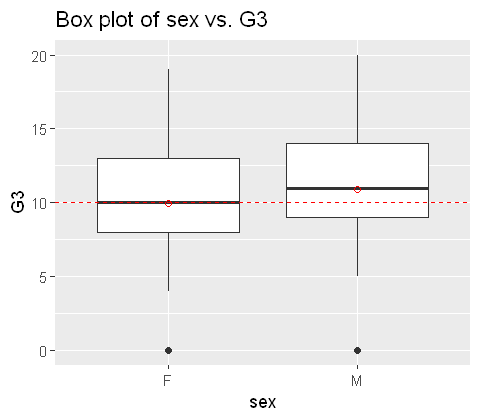

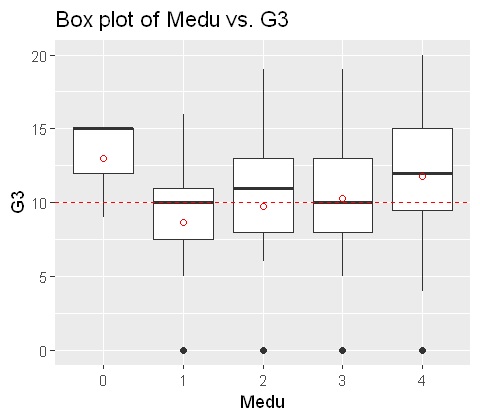

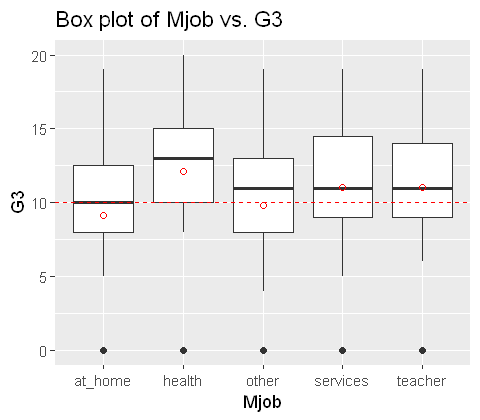

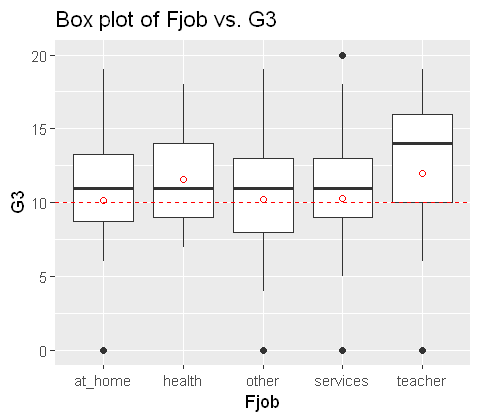

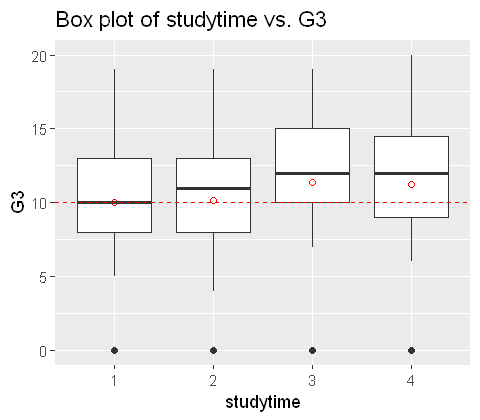

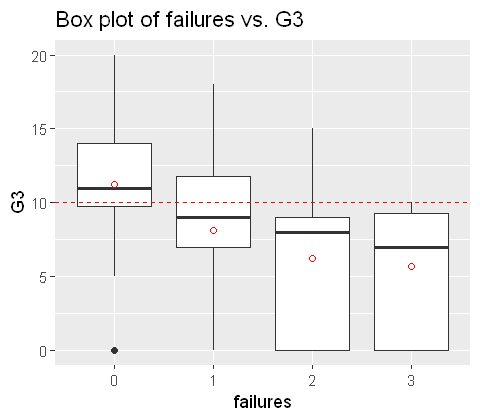

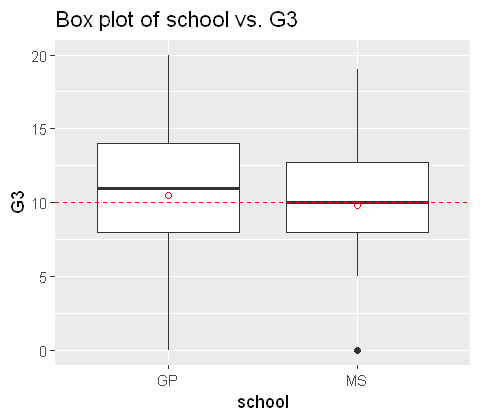

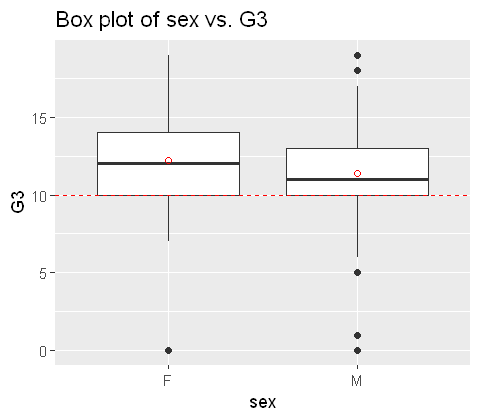

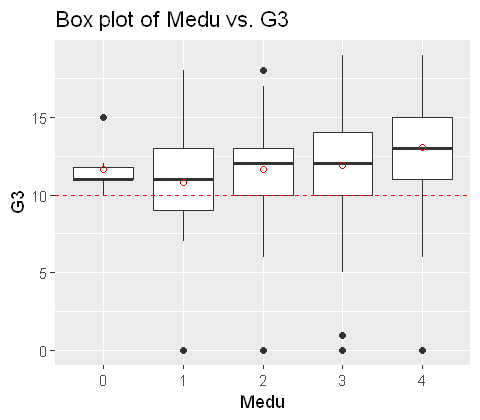

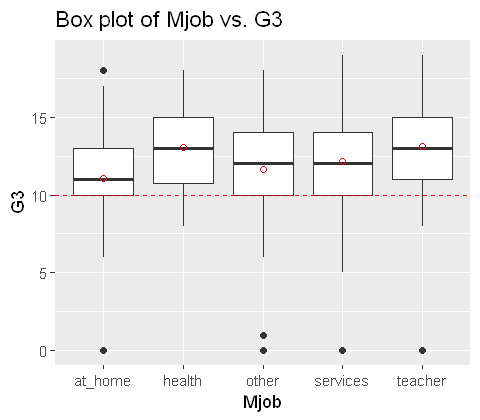

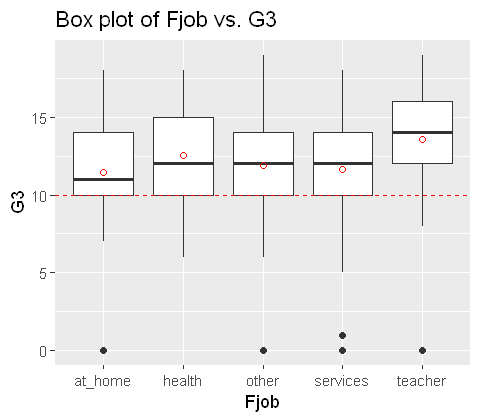

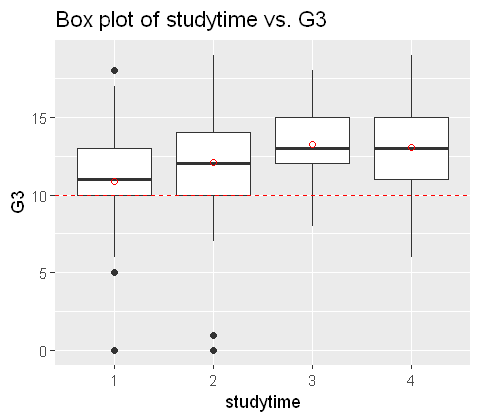

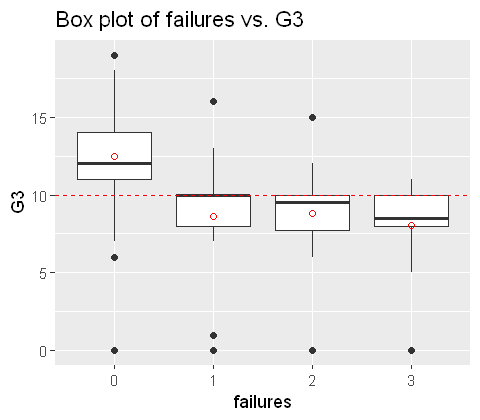

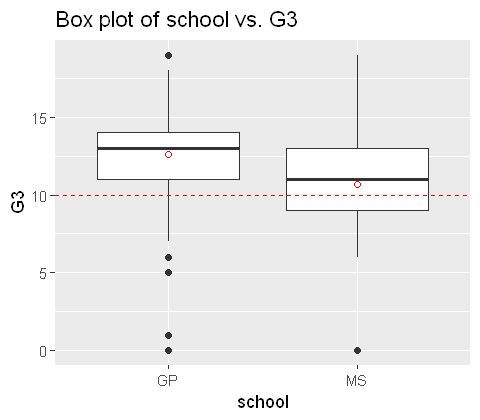

In [42]:
#### boxplot to show key variables for lasso or ridge ####
# for categorical variables
boxplot = function(df, cols, col_y = 'G3'){
    options(repr.plot.width=4, repr.plot.height=3.5) # Set the initial plot area dimensions
    for(col in cols){
        p = ggplot(df, aes_string(col, col_y)) + 
            geom_boxplot() +
            ggtitle(paste('Box plot of', col, 'vs.', col_y))
        print(p + geom_hline(yintercept = 10, col ='red', linetype="dashed")+stat_summary(fun.y=mean,shape=1,col='red',geom='point'))
    }
}
cat.cols = c('sex', 'Medu', 'Mjob', 'Fjob', 'studytime', 'failures', 'school')
boxplot(math2, cat.cols) # box plot for math
boxplot(port2, cat.cols) # box plot for port

‘Mjobservices’ and ‘Fjobteacher’ have the largest positive influence on Mathematics grade in the Lasso and Ridge regressions respectively. 

A student scores higher when his or her father is a teacher, as compared to other fathers’ occupations.

‘schoolMS’ influences Portuguese grade negatively in both Lasso (-0.99) and Ridge (-1.07) regressions. The average Portuguese grades are higher for Gabriel Pereira (GP).


Both shrinkage models emphasize the significance of parents’ education and job in determining a student’s grade. There is no bias for ‘failures’ in both Ridge and Lasso regressions. 


## Tree based methods

A regression tree starts by making a decision based on a flow chart to predict a continuous value (e.g. final grade, G3). 

The starting question, ‘Do the students have any failures for the subject?’ (also known as the root node) is split into two branches (yes or no) and this tree grows based on a sequence of questions asked about the features (e.g. absences, failures…). It stops at the leaf nodes when it cannot be split further. Decision trees tend to grow to a large size and overfit the data. Therefore, the minimum complexity parameter (cp) is used to select the optimal tree size to prevent overfitting. The main split for both subjects is based on ‘failures’.

In [43]:
#### Regression tree ####
reg.tree = function(train){ # regression tree on train set 
    rtree = rpart(G3~., train, method='anova')
    rtree 
}   

In [44]:
# prune the tree based on the complexity parameter
reg.tree.prune = function(rtree=reg.tree){ # find the model with min complexity parameter
    min.cp = rtree$cptable[which.min(rtree$cptable[,"xerror"]),"CP"]
    prune.rtree = prune(rtree, cp=min.cp)
    prune.rtree 
}

In [45]:
# set prune.rtree
prune.rtree.m = reg.tree.prune(reg.tree(m.train)) # prune tree for math
prune.rtree.p = reg.tree.prune(reg.tree(p.train)) # prune tree for port

# predict on rmse
reg.tree.rmse = function(prune.rtree=reg.tree.prune, test){ #rmse
    tree.pred = predict(prune.rtree, newdata=test)
    tree.pred.rmse = RMSE(test$G3 - tree.pred)
    return(tree.pred.rmse)
}

In [46]:
# Methods
reg.tree.rmse(prune.rtree=reg.tree.prune(reg.tree(train=m.train)), test=m.test)
# 4.25

reg.tree.rmse(prune.rtree=reg.tree.prune(reg.tree(train=p.train)), test=p.test)
# 3.02

[1] 4.25

[1] 2.97

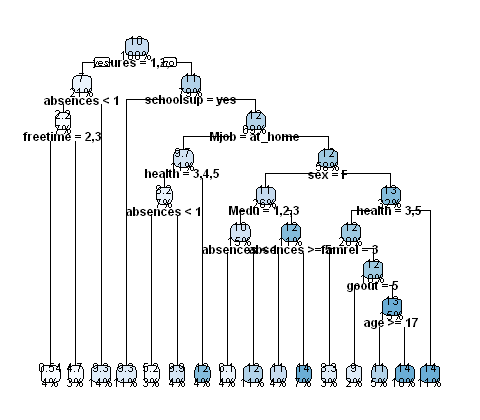

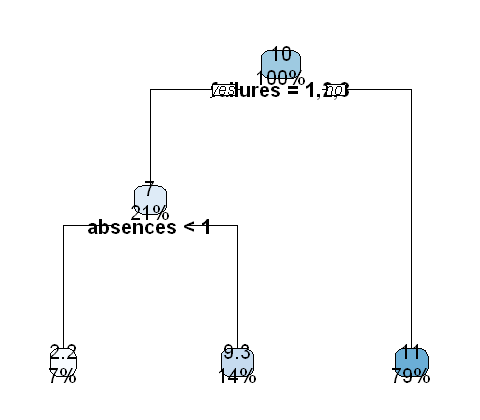

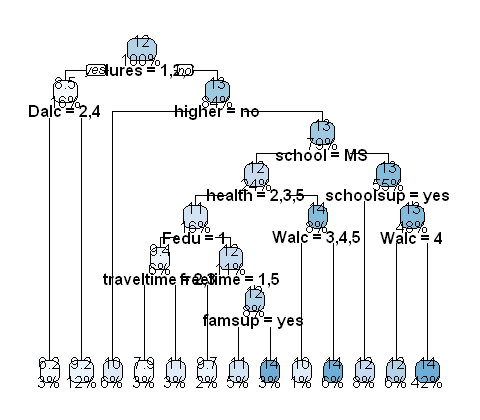

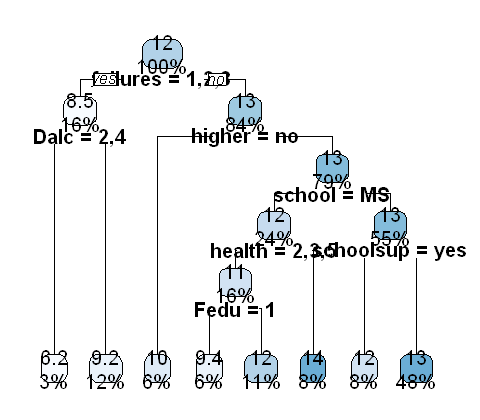

In [47]:
# plot both prune and full tree
trees.plot=function(rtree=reg.tree, prune.rtree=reg.tree.prune){ #plots
    rpart.plot(rtree, roundint=FALSE) # plot tree
    rpart.plot(prune.rtree, roundint=FALSE, cex=1) # pruned tree
} 
# Methods:
# prune.rtree = reg.tree.prune(rtree=reg.tree(train=m.train))
trees.plot(rtree=reg.tree(train=m.train), prune.rtree=prune.rtree.m) # m.train
trees.plot(rtree=reg.tree(train=p.train), prune.rtree=prune.rtree.p) # p.train

In [49]:
m.rules = rpart.rules(prune.rtree.m, roundint=FALSE)
p.rules = rpart.rules(prune.rtree.p, roundint=FALSE)

m.rules
p.rules

,G3,,,,,,,,
4,2.2,when,failures,is,1 or 2 or 3,&,absences,<,1
5,9.3,when,failures,is,1 or 2 or 3,&,absences,>=,1
3,11.4,when,failures,is,0,,,,


,G3,,.1,.2,.3,.4,.5,.6,.7,.8,...,,.1,.2,.3,.4,.5,.6,.7,.8,.9
4,6.2,when,failures,is,1 or 2 or 3,,,,,,...,is,2 or 4,,,,,,,,
5,9.2,when,failures,is,1 or 2 or 3,,,,,,...,is,1 or 3 or 5,,,,,,,,
56,9.4,when,failures,is,0,&,higher,is,yes,&,...,,,,,,,&,Fedu,is,1
6,10.0,when,failures,is,0,&,higher,is,no,,...,,,,,,,,,,
30,11.6,when,failures,is,0,&,higher,is,yes,&,...,,,&,schoolsup,is,yes,,,,
57,11.8,when,failures,is,0,&,higher,is,yes,&,...,,,,,,,&,Fedu,is,0 or 2 or 3 or 4
31,13.4,when,failures,is,0,&,higher,is,yes,&,...,,,&,schoolsup,is,no,,,,
29,13.5,when,failures,is,0,&,higher,is,yes,&,...,,,,,,,,,,


In [216]:
rpart.rules(reg.tree(m.train))

,G3,,.1,.2,.3,.4,.5,.6,.7,.8,...,,.1,.2,.3,.4,.5,.6,.7,.8,.9
8,0.58,when,failures,is,1 or 2 or 3,&,absences,<,1,,...,,,&,freetime,is,2 or 3,,,,
9,4.67,when,failures,is,1 or 2 or 3,&,absences,<,1,,...,,,&,freetime,is,1 or 4 or 5,,,,
48,6.20,when,failures,is,0,&,absences,<,1,&,...,is,course or home or other,,,,,,,,
26,9.07,when,failures,is,0,&,absences,>=,1,&,...,,,,,,,,,,
5,9.39,when,failures,is,1 or 2 or 3,&,absences,>=,1,,...,,,,,,,,,,
14,9.56,when,failures,is,0,,,,,&,...,,,,,,,,,,
49,10.00,when,failures,is,0,&,absences,<,1,&,...,is,course or home or other,,,,,,,,
54,11.42,when,failures,is,0,&,absences,>=,1,&,...,,,,,,,&,Fjob,is,at_home or health or other or services
30,12.59,when,failures,is,0,,,,,&,...,,,,,,,,,,
25,13.22,when,failures,is,0,&,absences,<,1,&,...,is,reputation,,,,,,,,


•	Average mathematics score is 10.

•	7% of the students scored 2.2 on average if their failures are more than 0 and have no absences. 

•	14% of the students score 9.3 on average if they fail once or multiple times and are absent more than once.

•	79% of the students scored 11 on average if they do not fail the subject at all.


The regression tree is more complex for Portuguese grades. They are predicted by weekday alcohol consumption (Dalc), father’s education (Fedu), weekend alcohol consumption (Walc) and if school supplementation is provided (schoolsup).
48% of the students scored 13 on average if they are not from ‘school=MS’ and have no school supplementation (schoolsup = no).


## Random forest

The Random Forest constructs multiple decision trees randomly to predict the final grade, G3. A random subset of predictors is chosen from the overall set of predictors. This algorithm does not rely on significant predictors but allows the predictors in the random subset to be the splitting criteria which result in a lowered variability of the grown tree. The importance of each predictor (variable importance) can be ranked based on how useful they are in constructing the multiple decision trees. 

‘failures’ is ranked at the top for both subjects. Similarly, the initial regression tree sets the starting decision based on the number of failures. This re-affirms the usefulness of failures as a predictor in both cases. 


In [54]:
#### Random forest ####
ranfor = function(train){ # ranfor is randomforest
    rf = randomForest(
        G3~., 
        data=train, 
        mtry=dim(train)[2]/3, 
        importance=TRUE) # mtry=p/3
    return(rf)
}

In [55]:
rf.rmse = function(rf=ranfor, test){
    pred = predict(rf, newdata=test)
    rmse = RMSE(test$G3 - pred)
    return(rmse)
}
#  Method
rf.rmse(rf=ranfor(train=m.train), test=m.test) # rmse random forest for math
# 4.09 

rf.rmse(rf=ranfor(train=p.train), test=p.test) # rmse random forest for port
# 2.8

[1] 4.04

[1] 2.77

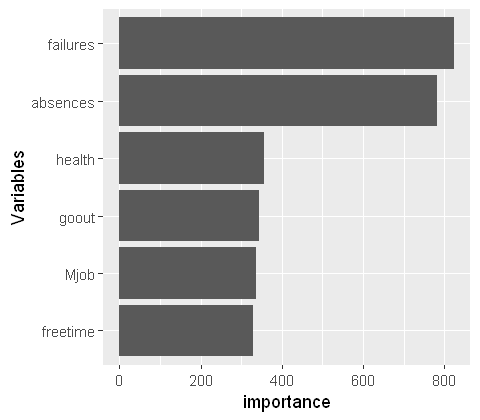

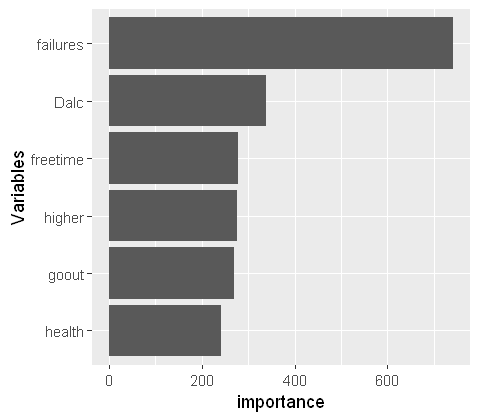

In [56]:
# variable importance plot
imp.plot = function(rf){
    x = data.frame(tail(sort(importance(rf)[,2])))
    colnames(x) = c('importance')
    
    # Barplot
    ggplot(x, aes(x=reorder(rownames(x), importance), y=importance)) + 
        geom_bar(stat = "identity") + labs(x = 'Variables') +
        coord_flip()
}

# Methods
imp.plot(ranfor(m.train))
imp.plot(ranfor(p.train))

## Results

In [60]:
#### Record all details ####
# errors for math
records.math = data.frame(matrix(NA, nrow=7, ncol=1)) # math
colnames(records.math) = c('Test RMSE')
rownames(records.math)=c('Linear Regression (Full Model)',
                     'Forward Selection',
                      'Backward Selection', 
                      'Lasso',
                      'Ridge',
                      'Regression Tree',
                      'Random Forest') 

# record errors for port
records.port = data.frame(matrix(NA, nrow=7, ncol=1))
colnames(records.port)=c('Test RMSE')
rownames(records.port)=c('Linear Regression (Full model)',
                     'Forward Selection',
                      'Backward Selection',  
                      'Lasso',
                      'Ridge',
                      'Regression Tree',
                      'Random Forest') 

#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
##### all functions and methods to store the results ####
store = function(train, test, records){
    records[1,1] = lin.reg(train, test)
    slt.forward = stepwise(train, test, method='forward')
    fwd = step.min.test(step.test(test, slt=slt.forward))
    records[2,1]=fwd
    slt.backward = stepwise(train, test, method='backward')
    bwd = step.min.test(step.test(test, slt=slt.backward))
    records[3,1]=bwd
    records[4,1]=regularizer(train, test, alpha =1)[1]
    records[5,1]=regularizer(train, test, alpha =0)[1]
    records[6,1]=reg.tree.rmse(prune.rtree=reg.tree.prune(reg.tree(train)), test)
    records[7,1]=rf.rmse(rf=ranfor(train), test)
    return(records)
}

In [62]:
math.results = data.frame(store(train=m.train, m.test, records=records.math))
port.results = data.frame(store(train=p.train, p.test, records=records.port)) 

math.results
port.results

,Test.RMSE
Linear Regression (Full Model),4.73
Forward Selection,4.47
Backward Selection,4.38
Lasso,4.41
Ridge,4.40
Regression Tree,4.25
Random Forest,4.01


,Test.RMSE
Linear Regression (Full model),2.91
Forward Selection,2.77
Backward Selection,2.74
Lasso,2.77
Ridge,2.77
Regression Tree,2.92
Random Forest,2.79


The Random forest algorithm (RMSE = 4.06) excels in predicting Mathematics grades while the Backwards Stepwise model (RMSE = 2.74) is the best in predicting Portuguese grades. 
Backwards stepwise model for Portuguese uses more predictors than the forward stepwise model and its RMSE only differs by a small difference of 0.03. 

The forward stepwise can explain the Portuguese grades with significantly lesser predictors. The variability between the models’ RMSE in predicting Portuguese grades is small as compared to Mathematics grades.


‘failures’ along with parental roles in the household (Mjob, Medu, Fjob, Fedu) are found to be influential on the final grades. Students who failed more than once, find it difficult to attain a higher grade in the final semester. The linear regression has the best interpretability whereby the predicted grades are determined by a linear combination of all the predictors however it is prone to overfitting. 
